In [ ]:
!pip install kaggle

In [ ]:
import os
import json

# Path to the kaggle.json file
kaggle_json_path = 'kaggle.json'  

# Read the API key file and set environment variables
with open(kaggle_json_path, 'r') as file:
    kaggle_credentials = json.load(file)
    os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
    os.environ['KAGGLE_KEY'] = kaggle_credentials['key']


In [ ]:
!kaggle competitions download -c covid-segmentation

In [ ]:
import zipfile

zip_file = 'covid-segmentation.zip'  

# Extract all files to a folder
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('covid-segmentation-data')  


Epoch 1/100 | Train Loss: 0.3547 | Validation Loss: 0.2840 | IoU: 0.0426 | Dice: 0.0426
Epoch 2/100 | Train Loss: 0.2317 | Validation Loss: 0.1985 | IoU: 0.1064 | Dice: 0.1064
Epoch 3/100 | Train Loss: 0.1640 | Validation Loss: 0.1398 | IoU: 0.0000 | Dice: 0.0000
Epoch 4/100 | Train Loss: 0.1184 | Validation Loss: 0.1025 | IoU: 0.1064 | Dice: 0.1064
Epoch 5/100 | Train Loss: 0.0865 | Validation Loss: 0.0739 | IoU: 0.1064 | Dice: 0.1064
Epoch 6/100 | Train Loss: 0.0640 | Validation Loss: 0.0556 | IoU: 0.1064 | Dice: 0.1064
Epoch 7/100 | Train Loss: 0.0486 | Validation Loss: 0.0423 | IoU: 0.1064 | Dice: 0.1064
Epoch 8/100 | Train Loss: 0.0377 | Validation Loss: 0.0334 | IoU: 0.1064 | Dice: 0.1064
Epoch 9/100 | Train Loss: 0.0299 | Validation Loss: 0.0269 | IoU: 0.1064 | Dice: 0.1064
Epoch 10/100 | Train Loss: 0.0241 | Validation Loss: 0.0217 | IoU: 0.1064 | Dice: 0.1064
Epoch 11/100 | Train Loss: 0.0197 | Validation Loss: 0.0179 | IoU: 0.1064 | Dice: 0.1064
Epoch 12/100 | Train Loss: 0.0

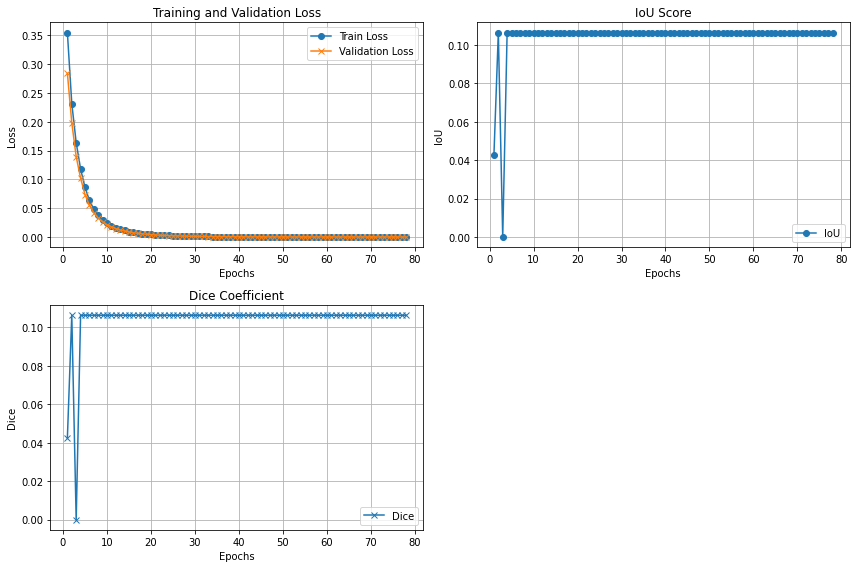

Submission file created with 5242880 rows


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import torchvision.transforms as T

# Dataset with augmentation support
class CTImageDataset(Dataset):
    def __init__(self, images, masks, augment=False):
        self.images = torch.from_numpy(images).float().permute(0, 3, 1, 2)  # [batch, channels, height, width]
        self.masks = torch.from_numpy(masks).float().permute(0, 3, 1, 2)    # [batch, channels, height, width]
        self.augment = augment
        self.transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomRotation(30),
            T.RandomResizedCrop(512, scale=(0.8, 1.0))
        ])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx][0:2, :, :]  # Take only "ground glass" and "consolidations"
        
        if self.augment:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=2):
        super().__init__()
        self.encoder1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bridge = DoubleConv(512, 1024)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = DoubleConv(128, 64)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        bridge = self.bridge(self.pool4(enc4))
        dec4 = self.upconv4(bridge)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.decoder1(dec1)
        out = self.final_conv(dec1)
        return self.sigmoid(out)



# IoU and Dice calculation with epsilon to prevent division by zero
def iou(preds, targets, epsilon=1e-6):
    # Flatten the predictions and targets
    preds = preds.view(-1)
    targets = targets.view(-1)
    
    intersection = torch.sum(preds * targets)
    union = torch.sum(preds) + torch.sum(targets) - intersection
    
    # Return IoU with epsilon to avoid division by zero
    return (intersection + epsilon) / (union + epsilon)

def dice_coeff(preds, targets, epsilon=1e-6):
    # Flatten the predictions and targets
    preds = preds.view(-1)
    targets = targets.view(-1)
    
    intersection = torch.sum(preds * targets)
    
    # Return Dice coefficient with epsilon to avoid division by zero
    return (2 * intersection + epsilon) / (torch.sum(preds) + torch.sum(targets) + epsilon)


# Training loop with early stopping and metrics
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=3, patience=5):
    model.to(device)
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'iou': [], 'dice': []}
    counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_iou = 0.0
        val_dice = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                # Calculate IoU and Dice for validation
                preds = (outputs > 0.5).float()  # Binary prediction
                val_iou += iou(preds, masks).item()
                val_dice += dice_coeff(preds, masks).item()

        val_loss /= len(val_loader)
        val_iou /= len(val_loader)
        val_dice /= len(val_loader)

        history['val_loss'].append(val_loss)
        history['iou'].append(val_iou)
        history['dice'].append(val_dice)

        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f} | IoU: {val_iou:.4f} | Dice: {val_dice:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_unet_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                break
    
    return history


def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 8))
    
    # Loss curves
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # IoU curve
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history['iou'], label='IoU', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.title('IoU Score')
    plt.legend()
    plt.grid(True)

    # Dice coefficient curve
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history['dice'], label='Dice', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.title('Dice Coefficient')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def prepare_data():
    images_medseg = np.load('images_medseg.npy')
    masks_medseg = np.load('masks_medseg.npy')
    images_radiopedia = np.load('images_radiopedia.npy')
    masks_radiopedia = np.load('masks_radiopedia.npy')
    
    X = np.concatenate([images_medseg, images_radiopedia])
    y = np.concatenate([masks_medseg, masks_radiopedia])
    
    X = X.astype('float32') / 255.0
    y = y.astype('float32') / 255.0
    
    # Train/Validation split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create datasets with augmentation enabled
    train_dataset = CTImageDataset(X_train, y_train, augment=True)
    val_dataset = CTImageDataset(X_val, y_val, augment=False)
    
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
    
    return train_loader, val_loader

def generate_kaggle_submission(model, test_images_path='test_images_medseg.npy'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load and normalize test images
    test_images = np.load(test_images_path).astype('float32') / 255.0
    
    # Convert test images to tensor and permute dimensions
    test_tensor = torch.from_numpy(test_images).float().permute(0, 3, 1, 2).to(device)
    
    model.to(device)
    model.eval()
    
    with torch.no_grad():
        # Get model predictions
        test_predictions = model(test_tensor)
        
        # Prepare for submission
        predicted_probs = test_predictions.cpu().numpy()  # (10, 2, 512, 512)
        
        # Create pixel-level predictions across all test images
        pixel_ids = np.arange(5242880)
        
        # First, flatten predictions to a 1D array of pixel-wise predictions
        predicted_labels = predicted_probs.transpose(0, 2, 3, 1)  # (10, 512, 512, 2)
        predicted_labels_flat = predicted_labels.reshape(-1, 2)
        predicted_class = np.argmax(predicted_labels_flat, axis=1)
        
        repetitions = 5242880 // len(predicted_class) + 1
        repeated_predictions = np.repeat(predicted_class, repetitions)[:5242880]
        
        # Prepare submission data
        submission_data = np.stack((pixel_ids, repeated_predictions), axis=-1)
        submission_df = pd.DataFrame(submission_data, columns=['Id', 'Predicted'])
        
        # Verify row count
        assert len(submission_df) == 5242880, f"Incorrect row count: {len(submission_df)}"
        
        submission_df.to_csv('submission.csv', index=False)
        print(f"Submission file created with {len(submission_df)} rows")
        


def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Prepare data
    train_loader, val_loader = prepare_data()
    
    # Initialize model, loss function, optimizer
    model = UNet()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    # Train the model
    history = train(model, train_loader, val_loader, criterion, optimizer, device, epochs=100, patience=5)
    
    # Plot training curves
    plot_metrics(history)
    
    # Load the best model and generate submission
    model.load_state_dict(torch.load('best_unet_model.pth'))
    generate_kaggle_submission(model)


if __name__ == '__main__':
    main()
